## Detección de Phishing: Chat en redes sociales

#### 1. Introducción
En este notebook, entrenaremos un modelo para detectar mensajes de phishing en redes sociales. Utilizaremos un conjunto de datos que contiene ejemplos de mensajes tanto de phishing como de no-phishing.

#### 2. Instalamos librerias requeridas

In [57]:
!pip install scikit-learn seaborn numpy

#### 3. Importacion de librerias

In [49]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#### 4. Cargamos el conjunto de datos
El archivo CSV que se genero con el notebook `dataset-generation.ipynb`, deberia estar en el mismo directorio que esta notebook actual.

In [50]:
file_path = "dataset_phishing_2023-08-16.csv"
df = pd.read_csv(file_path, sep='\t')

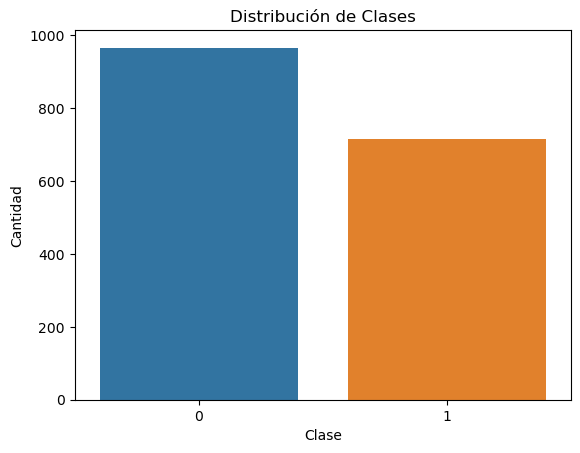

In [51]:
sns.countplot(x='phishing', data=df)
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()


#### 5. Preprocesamiento de datos
Dividiremos el conjunto de datos en conjuntos de entrenamiento y prueba, y luego transformaremos los mensajes en vectores numéricos usando TF-IDF.

In [56]:
stop_words = set(stopwords.words('spanish'))
ps = PorterStemmer()

def preprocess_text(text):
    # Reemplazar números de CBU con un token específico
    text = re.sub(r'\b\d{20}\b', 'CBUTOKEN', text)
    # Reemplazar números de cuenta con un token específico
    text = re.sub(r'\b\d{4}/\d{8}/\d{2}\b|\b\d{14}\b', 'ACCOUNTNUMBERTOKEN', text)
    # Reemplazar números de teléfono de WhatsApp (Argentina) con un token específico
    text = re.sub(r'\+\d{13}|\b\d{10}\b', 'WHATSAPPTOKEN', text)
    # Reemplazar montos con un token específico
    text = re.sub(r'\$\d+', 'MONTOTOKEN', text)
    # Reemplazar URLs por un token específico
    text = re.sub(r'http\S+|www\S+', 'URLTOKEN', text)
    # Eliminar acentos
    text = unidecode(text)
    # Convertir a minúscula y eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Eliminar números
#     text = re.sub(r'\d+', '', text)
#     Eliminar palabras vacías y aplicar stemming
#     text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    return text

x = df['message'].apply(preprocess_text)
y = df['phishing']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#### 5. Entrenamos el modelo

In [57]:
clf = MultinomialNB()

# Ajustamos (entrenamos) el modelo con los datos de entrenamiento
clf.fit(X_train_tfidf, y_train)


MultinomialNB()

#### 6. Evaluamos el modelo

In [58]:
y_pred = clf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       189
           1       0.99      0.95      0.97       148

    accuracy                           0.97       337
   macro avg       0.97      0.97      0.97       337
weighted avg       0.97      0.97      0.97       337

Accuracy: 0.973293768545994


In [65]:
new_message = "Hola gordoooo"
new_message_preprocessed = preprocess_text(new_message)
print(new_message_preprocessed)
# Luego puedes vectorizar y hacer la predicción como lo hiciste antes
new_message_tfidf = tfidf_vectorizer.transform([new_message_preprocessed])
prediction = clf.predict(new_message_tfidf)

# Interpretamos el resultado
if prediction[0] == 0:
    print("El mensaje es legítimo")
else:
    print("El mensaje es phishing")


hola gordoooo
El mensaje es phishing


#### Plots

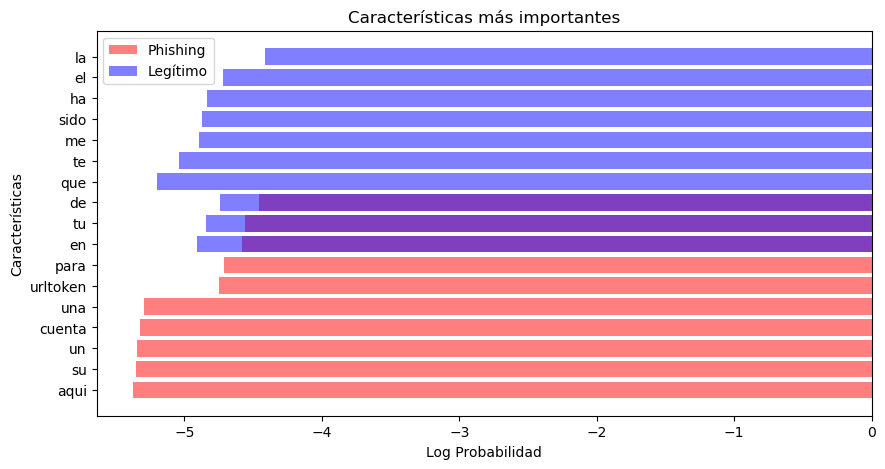

In [27]:
def plot_important_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names_out()
    log_prob = clf.feature_log_prob_
    phishing_prob = log_prob[1]
    legitimate_prob = log_prob[0]

    top_phishing_indices = np.argsort(phishing_prob)[-n:]
    top_legitimate_indices = np.argsort(legitimate_prob)[-n:]

    top_phishing_features = [feature_names[i] for i in top_phishing_indices]
    top_legitimate_features = [feature_names[i] for i in top_legitimate_indices]

    plt.figure(figsize=(10, 5))
    plt.barh(top_phishing_features, phishing_prob[top_phishing_indices], color='r', alpha=0.5, label='Phishing')
    plt.barh(top_legitimate_features, legitimate_prob[top_legitimate_indices], color='b', alpha=0.5, label='Legítimo')
    plt.title('Características más importantes')
    plt.xlabel('Log Probabilidad')
    plt.ylabel('Características')
    plt.legend()
    plt.show()

plot_important_features(tfidf_vectorizer, clf)


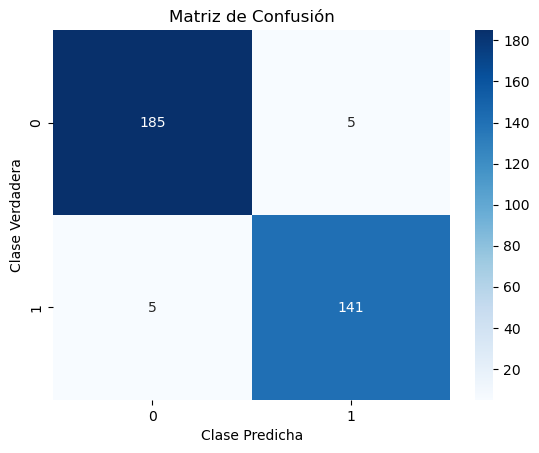

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculamos la matriz de confusión
y_pred = clf.predict(X_test_tfidf)
conf_mat = confusion_matrix(y_test, y_pred)

# La visualizamos como un heatmap
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.title('Matriz de Confusión')
plt.show()